In [2]:
"""A set of functions that can be used to compare Randomized Response to RAPPOR

This library contains functions that can generate random PMFs, draw samples from
a given PMF, enocde data using both RAPPOR and Randomized Response, and apply
various decoders for both RAPPOR and Randomized Response.
"""

import numpy as np
import random
import math
import matplotlib.pyplot as plt

def ml_decoder(counts, n):
  """Implements the maximum likelihood estimator (ML) of a distribution.

  Args:
    counts: A 1-d array containing the number of times each element showed up.
    n: The number of samples.
  """
  return counts / float(n)


def map_decoder(counts, params, n):
  """Implements the MAP estimator of a distribution under a Dirichlet prior.

  Args:
    counts: A 1-d array containing the number of times each element showed up.
    params: A 1-d numpy array containing the parameters of a Dirichlet
      distribution.
    n: The number of samples.
  """
  return (counts + params) / float(n + sum(params))


def decode_counts(counts, epsilon, n, k):
  """Estimates PMF under RAPPOR and Randomized Response using standard decoding.

  Args:
    counts: An array containing the number of times each element showed up.
    epsilon: The differential privacy level. If decode_counts is used for RAPPOR
      epsilon/2 is passed to the function.
    n: The number of samples (users).
    k: The size of the alphabet. If decode_counts is used for RAPPOR k = 2 is
      passed to the function.
  """
  p_estimate = (counts / float(n)) * (
      (math.exp(epsilon) + k - 1) /
      (math.exp(epsilon) - 1)) - 1.0 / (math.exp(epsilon) - 1)
  return p_estimate


def truncate_and_normalize(p_estimate):
  """Truncates an estimated PMF and renormalizes it to sum to 1.

  Args:
    pmf_estimate: An estimate for the PMF.
  """
  p_estimate_rectified = np.maximum(p_estimate, 0)
  return p_estimate_rectified / sum(p_estimate_rectified)


def sample_dirichlet(params):
  """Samples a PMF from the probability simplex according to a Dirichlet dist.

  Args:
    params: A 1-d numpy array containing the parameters of a Dirichlet dist.
  """
  pmf = np.array([random.gammavariate(a, 1) for a in params])
  pmf = pmf / sum(pmf)
  return pmf


def discrete_pmf_samples(pmf, n):
  """Generates n samples from a given PMF.

  Args:
    pmf: A given PMF to be sampled from.
    n: The number of samples to be generated.
  """
  bins = np.cumsum(pmf)
  # Sample n samples from the alphabet according to the given PMF.
  samples = np.digitize(np.random.random_sample(n), bins)
  return samples


def randomized_response_encoder(samples, epsilon, k):
  """Encodes the samples using Randomized Response.

  Args:
    samples: The samples to be encoded.
    epsilon: The differential privacy level.
    k: The size of the alphabet.
  """
  n = len(samples)
  q = math.exp(epsilon) / (math.exp(epsilon) + k - 1)
  # Start by setting private_samples = samples.
  private_samples_rr = np.copy(samples)
  # Determine which samples need to be noised ("flipped").
  flip = np.random.random_sample(n) > q
  flip_samples = samples[flip]
  # Select new samples uniformly at random to replace the original ones.
  rand_samples = np.random.randint(0, k - 1, len(flip_samples))
  # Shift the samples if needed to avoid sampling the orginal samples.
  rand_samples[rand_samples >= flip_samples] += 1
  # Replace the original samples by the randomly selected ones.
  private_samples_rr[flip] = rand_samples
  return private_samples_rr


def encode_rappor(counts, epsilon, n):
  """Creates the count vector under RAPPOR.

  Args:
    counts: A 1-d numpy array containing a random draw from
      multinomial(n, original PMF).
    epsilon: The differential privacy level.
    n: The number of samples over which the count vector is to be computed.
  This function implements the efficient RAPPOR encoding algorithm described in:
  https://cs.corp.google.com/#piper///depot/google3/experimental/users/kairouz/Optimal_Decoding/private_distribution_estimation.pdf
  """
  counts_rappor = np.zeros(len(counts))
  q = math.exp(epsilon / 2.0) / (math.exp(epsilon / 2.0) + 1)
  for (i, count) in enumerate(counts):
    counts_rappor[i] = np.random.binomial(count,q) + np.random.binomial(
        n - count, 1 - q)
  return counts_rappor


def encode_randomized_response(pmf, epsilon, n):
  """Creates the count vector under Randomized Response.

  Args:
    pmf: A 1-d numpy array containing the original PMF.
    epsilon: The differential privacy level.
    n: The number of samples over which the count vector is to be computed.
  This function creates a random draw from multinomial(n, private PMF).
  Let q = exp(epsilon) / (exp(epsilon) + k - 1),  then RR is given by
    p(out | in) = q            if out == in
                = (1-q)/(k-1)  otherwise,
  and therefore, the private PMF is given by
    private_pmf[i] = p(out=i)
                   = sum_i p(out=i | in=i) p(in = i)
                   = q * pmf[i] + (1-q)/(k-1) * (1-pmf[i])
                   =  (exp(epsilon)* pmf[i] + 1 - pmf[i]) / (
                          exp(epsilon) + k - 1)
                   =  ( (exp(epsilon)-1)*pmf[i] + 1 ) / (
                          exp(epsilon) + k - 1)
  """
  # Compute M (the private PMF) = RR mechanism applied to P (the original PMF).
  private_pmf = ((math.exp(epsilon) - 1) * pmf + 1) / (
      math.exp(epsilon) + len(pmf) - 1)
  return np.random.multinomial(n, private_pmf)


def rappor_encoder(samples, epsilon, k):
  """Encodes the samples using RAPPOR.

  Args:
    samples: A 1-d numpy array of length n, where each entry is an integer in
      [0,k). These are the input values to be RAPPOR-encoded.
    epsilon: The differential privacy level.
    k: The size of the alphabet.
  """
  n = len(samples)
  users = range(n)
  q = math.exp(epsilon / 2.0) / (math.exp(epsilon / 2.0) + 1)
  # One-hot encode the input integers.
  private_samples_rappor = np.zeros((n, k))
  private_samples_rappor[users, samples] = 1
  # Flip the RAPPOR encoded bits with probability p = 1 - q.
  flip = np.random.random_sample((n, k))
  return np.logical_xor(private_samples_rappor, flip > q)


def project_probability_simplex(p_estimate):
  """Projects a PMF estimate onto the probability simplex.

  Args:
    pmf_estimate: A PMF estimate.
  This functions implements Algorithm 1 in http://arxiv.org/abs/1309.1541
  """
  k = len(p_estimate)  # Infer the size of the alphabet.
  p_estimate_sorted = np.sort(p_estimate)
  p_estimate_sorted[:] = p_estimate_sorted[::-1]
  p_sorted_cumsum = np.cumsum(p_estimate_sorted)
  i = 1
  while i < k:
    if p_estimate_sorted[i] + (1.0 / (i + 1)) * (1 - p_sorted_cumsum[i]) < 0:
      break
    i += 1
  lmd = (1.0 / i) * (1 - p_sorted_cumsum[i - 1])
  return np.maximum(p_estimate + lmd, 0)


def standard_rappor_decoder(counts_rappor, epsilon, n):
  """Decodes RAPPOR encoded samples using a standard decoder.

  Args:
    counts_rappor: A 1-d numpy array containing the counts under RAPPOR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  # Estimate the PMF using the count vector
  p_rappor = decode_counts(counts_rappor, epsilon / 2.0, n, 2)
  return np.maximum(p_rappor, 0)


def normalized_standard_rappor_decoder(counts_rappor, epsilon, n):
  """Decodes RAPPOR encoded samples using a normalized standard decoder.

  Args:
    counts_rappor: A 1-d numpy array containing the counts under RAPPOR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  # Estimate the PMF using the count vector.
  p_rappor = decode_counts(counts_rappor, epsilon / 2.0, n, 2)
  if np.amax(p_rappor) <= 0:
    p_rappor_rectified = np.zeros(len(counts_rappor))
  else:
    # Truncate the negative entries and renormalize the PMF to sum to 1.
    p_rappor_rectified = truncate_and_normalize(p_rappor)
  return p_rappor_rectified


def projection_rappor_decoder(counts_rappor, epsilon, n):
  """Decodes RAPPOR encoded samples using a projection decoder.

  Args:
    counts_rappor: A 1-d numpy array containing the counts under RAPPOR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  # Estimate the PMF using the count vector.
  p_rappor = decode_counts(counts_rappor, epsilon / 2.0, n, 2)
  # Project the PMF estimate onto the (k-1)-dimensional probability simplex.
  return project_probability_simplex(p_rappor)


def normalized_standard_rr_decoder(counts_rr, epsilon, n):
  """Decodes RR encoded samples using a normalized standard decoder.

  Args:
    counts_rr: A 1-d numpy array containing the counts under RR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  k = len(counts_rr)  # Infer the size of the alphabet.
  # Estimate the PMF using the count vector.
  p_rr = decode_counts(counts_rr, epsilon, n, k)
  # Check if truncation and renormalization is required.
  if np.amin(p_rr) < 0:
    # Truncate the negative entries and renormalize the PMF to sum to 1.
    p_rr_rectified = truncate_and_normalize(p_rr)
  else:
    p_rr_rectified = p_rr
  assert abs(np.sum(p_rr_rectified) - 1) < 1e-3
  return p_rr_rectified


def projection_rr_decoder(counts_rr, epsilon, n):
  """Decodes RR encoded samples using a projection decoder.

  Args:
    counts_rr: A 1-d numpy array containing the counts under RR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  k = len(counts_rr)  # Infer the size of the alphabet.
  # Estimate the PMF using the count vector.
  p_rr = decode_counts(counts_rr, epsilon, n, k)
  # Check if a projection onto the probability simplex is needed.
  if np.amin(p_rr) < 0:
    p_rr_rectified = project_probability_simplex(p_rr)
  else:
    p_rr_rectified = p_rr
  return p_rr_rectified


def maximum_likelihood_rr_decoder(counts_rr, epsilon, n):
  """Decodes RR encoded samples using a maximum likelihood decoder.

  Args:
    counts_rr: A 1-d numpy array containing the counts under RR.
    epsilon: The differential privacy level.
    n: The number of samples.
  """
  k = len(counts_rr)  # Infer the size of the alphabet.
  # Estimate the PMF using the count vector.
  p_rr = decode_counts(counts_rr, epsilon, n, k)
  # Check if water filling is required.
  if np.amin(p_rr) < 0:
    indices = np.argsort(counts_rr)
    p_rr_rectified = np.zeros(k)
    for i in xrange(k):
      p_rr_rectified[i] = 0
      normalized_sum = float(np.sum(counts_rr[indices[i + 1:]]))
      p_rr_rectified[i + 1:] = (counts_rr[indices[i + 1:]] / normalized_sum) * (
          1 + (k - i - 1.0) /
          (math.exp(epsilon) - 1)) - 1.0 / (math.exp(epsilon) - 1)
      if np.amin(p_rr_rectified) >= 0:
        break
    # Rearrange p_rr_rectified to follow the same sequence p_rr had.
    reverse_indices = np.zeros(k, dtype=np.int)
    reverse_indices[indices] = np.arange(k)
    p_rr_rectified = p_rr_rectified[reverse_indices]
  else:
    p_rr_rectified = p_rr
  return p_rr_rectified

l1 distance:  0.354229894328
prob_sum:  1.0


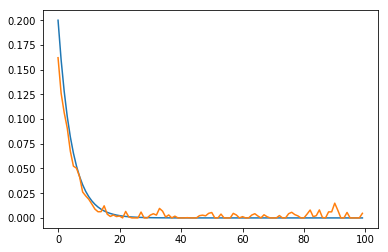

In [3]:
if __name__ == "__main__":
    k = 100 #absz
    n = 1000000
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist

    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, n, p=prob) #input symbols
    sample = randomized_response_encoder(in_list, eps, k)
    (outp, temp) = np.histogram(sample,range(k+1))
    #print outp
    prob_est = normalized_standard_rr_decoder(outp,eps,n) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))

l1 distance:  0.100687007303
prob_sum:  1.05761049306


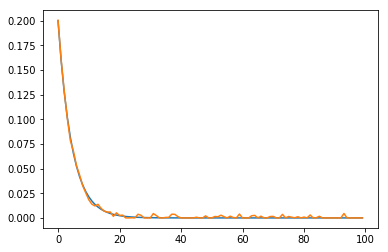

In [4]:
if __name__ == "__main__":
    sample = rappor_encoder(in_list, eps, k)
    outp = np.sum(sample, axis=0)
    prob_est = standard_rappor_decoder(outp,eps,n) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))